# 含并行连结的网络（GoogLeNet）

Inception块

In [1]:
import sys
sys.path.append('..')

In [2]:
from d2l import mindspore as d2l
from mindspore import nn, ops

In [4]:
class Inception(nn.Cell):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1, has_bias=True)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1, has_bias=True)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1, pad_mode='pad', has_bias=True)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1, has_bias=True)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2, pad_mode='pad', has_bias=True)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, pad_mode='same')
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1, has_bias=True)
        self.relu = nn.ReLU()
        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        p1 = self.relu(self.p1_1(x))
        p2 = self.relu(self.p2_2(self.relu(self.p2_1(x))))
        p3 = self.relu(self.p3_2(self.relu(self.p3_1(x))))
        p4 = self.relu(self.p4_2(self.p4_1(x)))
        return self.concat((p1, p2, p3, p4))

In [5]:
padding = 1
paddings = ((0, 0),) * 2 + ((padding, padding),) * 2
paddings

((0, 0), (0, 0), (1, 1), (1, 1))

GoogLeNet模型

In [6]:
b1 = nn.SequentialCell([
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, pad_mode='pad', has_bias=True),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')])

b2 = nn.SequentialCell([
    nn.Conv2d(64, 64, kernel_size=1, has_bias=True),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1, pad_mode='pad', has_bias=True),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')])

b3 = nn.SequentialCell([
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')])

b4 = nn.SequentialCell([
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')])

b5 = nn.SequentialCell([
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()])

net = nn.SequentialCell([b1, b2, b3, b4, b5, nn.Dense(1024, 10)])

为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96

In [7]:
X = ops.randn(1, 1, 96, 96)
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

SequentialCell output shape:	 (1, 64, 24, 24)
SequentialCell output shape:	 (1, 192, 12, 12)
SequentialCell output shape:	 (1, 480, 6, 6)
SequentialCell output shape:	 (1, 832, 3, 3)
SequentialCell output shape:	 (1, 1024)
Dense output shape:	 (1, 10)


训练模型

loss 0.355, train acc 0.919, test acc 0.883
2369.9 examples/sec


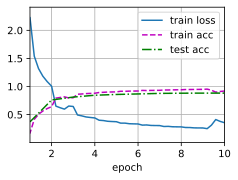

In [8]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)